In [2]:
# Imports packages

#Import linear algebra and data manipulation
import numpy as np
import pandas as pd

#Import plotting packages
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

#Import machine learning
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error
import AllTogether as t


In [5]:
# Read the data set
df = pd.read_csv('./Airbnb listings.csv')

# Find number of listings and unique number of hosts
listings_number = df['id'].count()
hosts_number = len(df['host_id'].unique())

print("Seatle has {listings} of listings and {hosts} of hosts".format(listings=listings_number, hosts=hosts_number))


Seatle has 3818 of listings and 2751 of hosts


# Question 1: What factors influence ratings?

In [6]:
# Selecting relevant columns to answer the questions
listings_df = df[["bathrooms", "bedrooms", "beds", "price", "cleaning_fee", "review_scores_rating"]]

## Data cleaning and prep
# Remove rows with missing values in bathrooms, bedrooms, beds columns
remove_column = ['bathrooms','bedrooms', 'beds']
listings_df.dropna(subset=remove_column, inplace=True)

# Strip price and cleaning fee columns and change data type to float
listings_df['price'] = listings_df['price'].str.replace(r'[$,]', '', regex=True).astype(float)
listings_df['cleaning_fee'] = listings_df['cleaning_fee'].str.replace(r'[$]', '', regex=True).astype(float)

# Calculate the mean value of fee and fill in missing data of cleaning fee
mean_fee = df["cleaning_fee"].str.strip('$').astype(float).mean()
listings_df["cleaning_fee"].fillna(mean_fee, inplace=True)

# Calculate the mean value of rating and fill in missing data of review_scores_rating
mean_rating = df["review_scores_rating"].mean()
listings_df["review_scores_rating"].fillna(mean_rating, inplace=True)

# Check whether there are any missing values in all columns
print(listings_df.isnull().sum())

bathrooms               0
bedrooms                0
beds                    0
price                   0
cleaning_fee            0
review_scores_rating    0
dtype: int64


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  import sys
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # Remove the CWD from sys.path while we load stuff.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-

In [7]:
## Training the model
X = listings_df[["price", "cleaning_fee"]]
y = listings_df["review_scores_rating"]

# Split data into training and test data, and fit a linear model
X_train, X_test, y_train, y_test = train_test_split(X, y , test_size=.10, random_state=42)
lm_model = LinearRegression(normalize=True)

# If our model works, it should just fit our model to the data. Otherwise, it will let us know.
try:
    lm_model.fit(X_train, y_train)
    y_test_preds = lm_model.predict(X_test) 
    print("The r-squared score for the model using only quantitative variables was {} on {} values.".format(r2_score(y_test, y_test_preds), len(y_test)))
    
except:
    print("Oh no! It doesn't work!!!")


The r-squared score for the model using only quantitative variables was 0.004404754271646327 on 380 values.


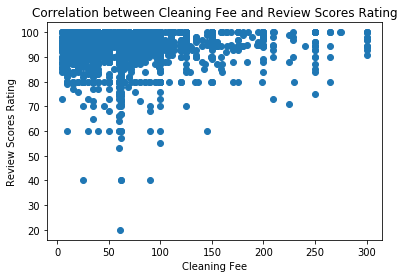

In [8]:
# Make a plot to visualise the correlation between cleaning fee and rating 
plt.scatter(x=listings_df["cleaning_fee"], y=listings_df["review_scores_rating"])
plt.xlabel("Cleaning Fee")
plt.ylabel("Review Scores Rating")
plt.title("Correlation between Cleaning Fee and Review Scores Rating")
plt.show()

# Question 2: How host respond services and rating influence availability?

In [9]:
# Selecting relevant columns to answer the questions
avail_factors = df[['host_response_time','host_response_rate','host_acceptance_rate', 'host_is_superhost', 'review_scores_rating', 
                    'availability_30', 'availability_60','availability_90', 'availability_365']]

## Data cleaning and prep
# Drop superhost column
avail_factors.dropna(subset=['host_is_superhost'], inplace=True)

# Replace categorical values with float for model training
response_map = {'within a few hours': 2, 'within an hour': 1, 'within a day': 3,'a few days or more': 4}
avail_factors['host_response_time'] = avail_factors['host_response_time'].replace(response_map)

superhost_map = {'f': 0, 't': 1}
avail_factors['host_is_superhost'] = avail_factors['host_is_superhost'].replace(superhost_map)

# Strip values and turn into float
avail_factors['host_response_rate'] = avail_factors['host_response_rate'].str.replace(r'[%,]', '', regex=True).astype(float)
avail_factors['host_acceptance_rate'] = avail_factors['host_acceptance_rate'].str.replace(r'[%,]', '', regex=True).astype(float)

# Find and fill in mean values for host_response_time, host_response_rate and host_acceptance_rate columns
def filling_mean(df, column_name):
    mean = df[column_name].mean()
    df[column_name].fillna(mean, inplace=True)

# Calling the function "filling_mean" to fill in mean values for empty rows
column_names = ["host_response_time", "host_response_rate", "host_acceptance_rate", "review_scores_rating"]
[filling_mean(avail_factors, column) for column in column_names]

# Check whether the data frame has empty values
print(avail_factors.isnull().sum())

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  import sys
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # This is added back by InteractiveShellApp.init_path()
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#index

host_response_time      0
host_response_rate      0
host_acceptance_rate    0
host_is_superhost       0
review_scores_rating    0
availability_30         0
availability_60         0
availability_90         0
availability_365        0
dtype: int64


/opt/conda/lib/python3.6/site-packages/pandas/core/generic.py:5434: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._update_inplace(new_data)


In [10]:
## Training the model
X = avail_factors[['host_response_time','host_response_rate','host_acceptance_rate', 'host_is_superhost', 'review_scores_rating']]
y = avail_factors[['availability_30', 'availability_60']]

# Split data into training and test data, and fit a linear model
X_train, X_test, y_train, y_test = train_test_split(X, y , test_size=.10, random_state=42)
lm_model = LinearRegression(normalize=True)

# If our model works, it should just fit our model to the data. Otherwise, it will let us know.
try:
    lm_model.fit(X_train, y_train)
    y_test_preds = lm_model.predict(X_test) 
    print("The r-squared score for the model using only quantitative variables was {} on {} values.".format(r2_score(y_test, y_test_preds), len(y_test)))
    
except:
    print("Oh no! It doesn't work!!!")

The r-squared score for the model using only quantitative variables was -0.005126527088201049 on 382 values.


# Question 3: How neighbourhood influences availability?

In [11]:
## Data cleaning and prep
# Selecting relevant columns to answer the questions
avail_factors = df[['neighbourhood_cleansed','neighbourhood_group_cleansed', 
                    'availability_30', 'availability_60','availability_90', 'availability_365']]

# Check whether the data frame has empty values
print(avail_factors.isnull().sum())

neighbourhood_cleansed          0
neighbourhood_group_cleansed    0
availability_30                 0
availability_60                 0
availability_90                 0
availability_365                0
dtype: int64


In [12]:
## Training the model
X = pd.get_dummies(avail_factors[['neighbourhood_cleansed','neighbourhood_group_cleansed']])
y = avail_factors[['availability_30', 'availability_60']]

# Split data into training and test data, and fit a linear model
X_train, X_test, y_train, y_test = train_test_split(X, y , test_size=.10, random_state=42)
lm_model = LinearRegression(normalize=True)

# If our model works, it should just fit our model to the data. Otherwise, it will let us know.
try:
    lm_model.fit(X_train, y_train)
    y_test_preds = lm_model.predict(X_test) 
    print("The r-squared score for the model using only quantitative variables was {} on {} values.".format(r2_score(y_test, y_test_preds), len(y_test)))
    
except:
    print("Oh no! It doesn't work!!!")

The r-squared score for the model using only quantitative variables was -0.04826558334942599 on 382 values.
